<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/laten_space_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import random
import cv2

from google.colab.patches import cv2_imshow
from skimage.feature import hog
from skimage import color

In [2]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
data = np.load('/content/drive/MyDrive/light_on_0.npz')
# print(data.files)
x, g, tx, ty, i, gi, ti = data['x'], data['gx'], data['tx'], data['tn'], data['i'], data['gi'], data['ti']

In [6]:
x.shape, g.shape, tx.shape

((1500, 128, 384, 3), (101, 128, 384, 3), (404, 128, 384, 3))

In [17]:
# normalize
x_norm = x/255
g_norm = g/255
tx_norm = tx/255

In [25]:
encoding_dim = 128
input_img = tf.keras.layers.Input(shape = x_norm.shape[1:]) # input layer

# encoder
encoded = tf.keras.layers.Conv2D(encoding_dim, kernel_size = (5, 5), padding = 'same', strides = 2,  activation = 'relu')(input_img)
encoded = tf.keras.layers.Conv2D(encoding_dim, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
encoded = tf.keras.layers.MaxPool2D(pool_size = (2, 2),)(encoded)
encoded = tf.keras.layers.Conv2D(encoding_dim/2, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
#encoded = tf.keras.layers.MaxPool2D(pool_size = (2, 2),)(encoded)
encoded = tf.keras.layers.Conv2D(encoding_dim/4, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
encoded = tf.keras.layers.Conv2D(encoding_dim/8, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
encoded = tf.keras.layers.Conv2D(3, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)

encoder = tf.keras.Model(input_img, encoded) # this maps an input to it's encoded representation

In [26]:
# latent representaion of x, g, tx
x_latent = encoder.predict(x_norm)
g_latent = encoder.predict(g_norm)
tx_latent = encoder.predict(tx_norm)

13/13 [==============================] - 0s 24ms/step


In [32]:
# saving encoded representation
np.savez_compressed("/content/drive/MyDrive/light_on_latent_0.npz", x_latent = x_latent, g_latent = g_latent, tx_latent = tx_latent, ty = ty, i = i, gi = gi, ti = ti)

In [5]:
data = np.load('/content/drive/MyDrive/light_on_latent_0.npz')
# print(data.files)
x_latent, g_latent, tx_latent, ty, i, gi, ti = data['x_latent'], data['g_latent'], data['tx_latent'], data['ty'], data['i'], data['gi'], data['ti']

In [6]:
x_latent.shape, g_latent.shape, tx_latent.shape

((1500, 32, 96, 3), (101, 32, 96, 3), (404, 32, 96, 3))

In [ ]:
# training siamene network on encoded representation of input

In [7]:
# creating batchs for traning (anchor, positive, and, negative (for triplet loss))
def create_batch(batch_size=500):
    x_anchors = np.zeros((batch_size, 32, 96, 3))
    x_positives = np.zeros((batch_size, 32, 96, 3))
    x_negatives = np.zeros((batch_size, 32, 96, 3))
    
    for j in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_latent.shape[0] - 1)
        x_anchor = x_latent[random_index]

        pos_index = random.randint(0, x_latent.shape[0] - 1)

        while pos_index == random_index or i[pos_index] != i[random_index]:
          pos_index = random.randint(0, x_latent.shape[0] - 1)

        x_positive = x_latent[pos_index]  # also for the same pallet block
        
        random_index_neg = random.randint(0, x_latent.shape[0] - 1)

        while random_index_neg == random_index or i[random_index] == i[random_index_neg]:
          random_index_neg = random.randint(0, x_latent.shape[0] - 1)
         
        x_negative = x_latent[random_index_neg]
        
        x_anchors[j] = x_anchor
        x_positives[j] = x_positive
        x_negatives[j] = x_negative
        
    x_anchors = np.expand_dims(x_anchors, axis = 1)
    x_positives = np.expand_dims(x_positives, axis = 1)
    x_negatives = np.expand_dims(x_negatives, axis = 1)

    k_con = np.concatenate([x_anchors, x_positives, x_negatives], axis = 1)
        
    return k_con

In [8]:
# embeding model
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(emb_size, kernel_size = (5, 5), strides = 2, padding = 'same', activation = 'relu', input_shape = (32, 96, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size/2, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size/4, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size/4, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(30)
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 48, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 16, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 24, 64)        0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 8, 24, 64)        256       
 hNormalization)                                                 
                                                        

In [9]:
# siamese network
siamese_input = tf.keras.Input(shape = (3, 32, 96, 3))
input_anchor =  siamese_input[:, 0]                                              #tf.keras.layers.Input(shape=(32, 96, 3))
input_positive = siamese_input[:, 1]                                             #tf.keras.layers.Input(shape=(32, 96, 3))
input_negative = siamese_input[:, 2]                                             #tf.keras.layers.Input(shape=(32, 96, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

embedding_anchor = k.expand_dims(embedding_anchor, 1)
embedding_negative = k.expand_dims(embedding_negative, 1)
embedding_positive = k.expand_dims(embedding_positive, 1)


output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1) 

model = tf.keras.models.Model(siamese_input, output)
model.summary()
     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 32, 96,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 32, 96, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 32, 96, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [10]:
alpha = 0.05

pos = k.mean((embedding_anchor - embedding_positive)**2, axis = 1)
neg = k.mean((embedding_anchor - embedding_negative)**2, axis = 1)

loss = k.mean(k.relu(pos - neg + alpha)) 

In [11]:
batch_size = 7000
x_train = create_batch(batch_size)
x_train = np.array(x_train)
x_train.shape

(7000, 3, 32, 96, 3)

In [12]:
# batch_size = 2048
epochs = 25
# steps_per_epoch = 25

model.add_loss(loss)


model.compile(optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

history = model.fit(
    x_train,
    batch_size = 100,
    epochs=epochs, verbose=True, callbacks = [callback], validation_split = 0.2)

Epoch 1/25
56/56 [==============================] - 20s 66ms/step - loss: 0.3118 - val_loss: 0.0500
Epoch 2/25
56/56 [==============================] - 3s 54ms/step - loss: 0.0526 - val_loss: 0.0500
Epoch 3/25
56/56 [==============================] - 3s 54ms/step - loss: 0.0504 - val_loss: 0.0500
Epoch 4/25
56/56 [==============================] - 3s 45ms/step - loss: 0.0501 - val_loss: 0.0500
Epoch 5/25
56/56 [==============================] - 3s 56ms/step - loss: 0.0501 - val_loss: 0.0500
Epoch 6/25
56/56 [==============================] - 4s 79ms/step - loss: 0.0500 - val_loss: 0.0500
Epoch 7/25
56/56 [==============================] - 3s 60ms/step - loss: 0.0500 - val_loss: 0.0500
Epoch 8/25
56/56 [==============================] - 3s 49ms/step - loss: 0.0500 - val_loss: 0.0500
Epoch 9/25
56/56 [==============================] - 3s 46ms/step - loss: 0.0500 - val_loss: 0.0500
Epoch 10/25
56/56 [==============================] - 3s 46ms/step - loss: 0.0500 - val_loss: 0.0500
Epoch 11

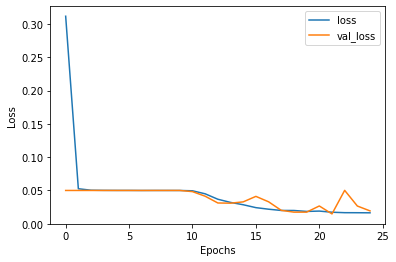

In [13]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['loss', 'val_loss'])
plt.show()

In [14]:
# predictions
x_predict = embedding_model.predict(x_latent)
g_predict = embedding_model.predict(g_latent)
t_predict = embedding_model.predict(tx_latent)

13/13 [==============================] - 0s 10ms/step


In [15]:
# saving siamese predictions
np.savez_compressed("/content/drive/MyDrive/light_on_siamese_0.npz", x_predict = x_predict, g_predict = g_predict, t_predict = t_predict, ty = ty, i = i, gi = gi, ti = ti)